In [1]:
import sys
import numpy as np
import pandas as pd
import uuid
import pickle
from IPython.display import display


%load_ext autoreload
%autoreload 2

sys.path.append("../")
from vpop_calibration import *

## Define a reference ODE model


In [2]:
# Define the reference PK model we will use for training the GP and generating a synthetic data set
def equations(t, y, k_a, k_12, k_21, k_el):
    # y[0] is A_absorption, y[1] is A_central, y[2] is A_peripheral
    A_absorption, A_central, A_peripheral = y[0], y[1], y[2]
    dA_absorption_dt = -k_a * A_absorption
    dA_central_dt = (
        k_a * A_absorption + k_21 * A_peripheral - k_12 * A_central - k_el * A_central
    )
    dA_peripheral_dt = k_12 * A_central - k_21 * A_peripheral

    ydot = [dA_absorption_dt, dA_central_dt, dA_peripheral_dt]
    return ydot


variable_names = ["A0", "A1", "A2"]
parameter_names = ["k_a", "k_12", "k_21", "k_el"]

ode_model = OdeModel(equations, variable_names, parameter_names)
print(ode_model.variable_names)
time_span = (0, 24)
nb_steps = 10
time_steps = np.linspace(time_span[0], time_span[1], nb_steps).tolist()

protocol_design = pd.DataFrame({"protocol_arm": ["arm-A", "arm-B"], "k_el": [0.5, 10]})
nb_protocols = len(protocol_design)

initial_conditions = np.array([10.0, 0.0, 0.0])

['A0', 'A1', 'A2']


## Train or load an existing GP surrogate


In [3]:
model_file = "gp_surrogate_pk_model.pkl"
folder_path = "./serialized_models/"

model_full_path = folder_path + model_file

use_pickle = True
override_existing_pickle = True

In [9]:
if (override_existing_pickle) or (not use_pickle):
    # Simulate a training data set using parameters sampled via Sobol sequences
    log_nb_patients = 8
    param_ranges = {
        "k_12": {"low": -2.0, "high": 0.0, "log": True},
        "k_21": {"low": -1.0, "high": 1.0, "log": True},
        "k_a": {"low": 0.0, "high": 1.0, "log": True},
    }

    print(f"Simulating {2**log_nb_patients} patients on {nb_protocols} scenario arms")
    dataset = simulate_dataset_from_ranges(
        ode_model,
        log_nb_patients,
        param_ranges,
        initial_conditions,
        protocol_design,
        None,
        None,
        time_steps,
    )

    learned_ode_params = list(param_ranges.keys())
    descriptors = learned_ode_params + ["time"]

    # Instantiate a GP
    myGP = GP(
        dataset,
        descriptors,
        var_strat="IMV",  # either IMV (Independent Multitask Variational) or LMCV (Linear Model of Coregionalization Variational)
        kernel="RBF",  # Either RBF or SMK
        data_already_normalized=False,  # default
        nb_inducing_points=100,
        mll="ELBO",  # default, otherwise PLL
        nb_training_iter=200,
        training_proportion=0.7,
        learning_rate=0.1,
        lr_decay=0.99,
        jitter=1e-6,
        log_inputs=learned_ode_params,
        log_outputs=variable_names,
    )
    # Train the GP
    myGP.train()

    if use_pickle and override_existing_pickle:
        with open(model_full_path, "wb") as file:
            pickle.dump(myGP, file)
        print(f"Model saved to {model_file}")
elif use_pickle and (not override_existing_pickle):
    try:
        with open(model_full_path, "rb") as file:
            myGP = pickle.load(file)

        print("Model loaded successfully!")

    except FileNotFoundError:
        print(
            f"File not found. Please make sure '{model_full_path}' exists and is in the correct directory."
        )

Simulating 256 patients on 2 scenario arms


100%|██████████| 200/200 [00:37<00:00,  5.40it/s, loss=-4.16] 


Model saved to gp_surrogate_pk_model.pkl


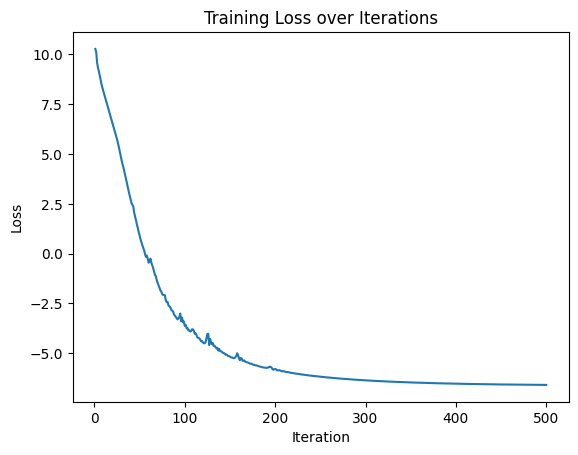

In [ ]:
myGP.plot_loss()

## Generate a synthetic data set using a NLME from the ODEs directly


In [10]:
time_span_rw = (0, 24)
nb_steps_rw = 10

# For each output and for each patient, give a list of time steps to be simulated
time_steps_rw = np.linspace(time_span_rw[0], time_span_rw[1], nb_steps_rw).tolist()

# Parameter definitions
true_log_MI = {"k_21": 0.0}
true_log_PDU = {
    "k_12": {"mean": -1.0, "sd": 0.25},
}
error_model_type = "additive"
true_res_var = [0.5, 0.02, 0.1]
true_covariate_map = {
    "k_12": {"foo": {"coef": "cov_foo_k12", "value": 0.2}},
}

# Create a patient data frame
# It should contain at the very minimum one `id` per patient
nb_patients = 50
patients_df = pd.DataFrame({"id": [str(uuid.uuid4()) for _ in range(nb_patients)]})
rng = np.random.default_rng()
patients_df["protocol_arm"] = rng.binomial(1, 0.5, nb_patients)
patients_df["protocol_arm"] = patients_df["protocol_arm"].apply(
    lambda x: "arm-A" if x == 0 else "arm-B"
)
patients_df["k_a"] = rng.lognormal(-1, 0.1, nb_patients)
patients_df["foo"] = rng.lognormal(0, 0.1, nb_patients)
display(patients_df)

print(f"Simulating {nb_patients} patients on {nb_protocols} protocol arms")
obs_df = simulate_dataset_from_omega(
    ode_model,
    protocol_design,
    time_steps,
    initial_conditions,
    true_log_MI,
    true_log_PDU,
    error_model_type,
    true_res_var,
    true_covariate_map,
    patients_df,
)

display(obs_df)

,id,protocol_arm,k_a,foo
0,608e0e62-92e9-478f-bec2-b9be421a7a4a,arm-A,0.382159,0.886167
1,4f44f512-f83e-46e4-ad53-20218899d84b,arm-B,0.347946,1.092673
2,bf6043a6-0302-446d-a76b-c4efbcb13732,arm-A,0.432952,1.301258
3,ae55b4d1-55d1-4db3-803f-f6770c705b2a,arm-A,0.366954,0.937402
4,d4b7c9e7-1461-4624-8ebd-5cd114ebce5e,arm-B,0.369883,0.937278
5,869c3293-ea63-486b-9b44-a3f3b9a318a5,arm-B,0.332403,1.005902
6,c579602e-8547-43ad-ad76-8efc3d8094b5,arm-A,0.343375,1.141941
7,cd068803-f7a2-415b-9738-562487a208c4,arm-A,0.363485,1.007669
8,814aac6f-7f39-4a4a-96ce-1fd21d2a66eb,arm-A,0.363144,0.840361
9,b93e8a7f-f355-4963-ad0b-dec3ba04e67b,arm-A,0.461388,1.096769


Simulating 50 patients on 2 protocol arms
Successfully loaded 1 covariates:
['foo']
Successfully loaded 1 known descriptors:
['k_a']


,k_a,k_12,k_21,id,protocol_arm,output_name,time,A0_0,A1_0,A2_0,k_el,value
0,0.382159,0.548853,1.0,608e0e62-92e9-478f-bec2-b9be421a7a4a,arm-A,A0,0.000000,10.0,0.0,0.0,0.5,10.000000
1,0.382159,0.548853,1.0,608e0e62-92e9-478f-bec2-b9be421a7a4a,arm-A,A0,2.666667,10.0,0.0,0.0,0.5,3.609227
2,0.382159,0.548853,1.0,608e0e62-92e9-478f-bec2-b9be421a7a4a,arm-A,A0,5.333333,10.0,0.0,0.0,0.5,1.302651
3,0.382159,0.548853,1.0,608e0e62-92e9-478f-bec2-b9be421a7a4a,arm-A,A0,8.000000,10.0,0.0,0.0,0.5,0.470157
4,0.382159,0.548853,1.0,608e0e62-92e9-478f-bec2-b9be421a7a4a,arm-A,A0,10.666667,10.0,0.0,0.0,0.5,0.169690
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0.360832,0.474873,1.0,7b50c4c1-6176-4ad1-bd62-a0a656ba1b9f,arm-A,A2,13.333333,10.0,0.0,0.0,0.5,0.203099
1496,0.360832,0.474873,1.0,7b50c4c1-6176-4ad1-bd62-a0a656ba1b9f,arm-A,A2,16.000000,10.0,0.0,0.0,0.5,0.103446
1497,0.360832,0.474873,1.0,7b50c4c1-6176-4ad1-bd62-a0a656ba1b9f,arm-A,A2,18.666667,10.0,0.0,0.0,0.5,0.051193
1498,0.360832,0.474873,1.0,7b50c4c1-6176-4ad1-bd62-a0a656ba1b9f,arm-A,A2,21.333333,10.0,0.0,0.0,0.5,0.024828


## Optimize the GP surrogate using SAEM


In [11]:
# Initial pop estimates
# Parameter definitions
init_log_MI = {}  # {"k_21": -1.0}
init_log_PDU = {
    "k_21": {"mean": -1.0, "sd": 0.2},
    "k_12": {"mean": -0.1, "sd": 0.1},
}
error_model_type = "additive"
init_res_var = [0.1, 0.05, 0.5]
init_covariate_map = {
    "k_12": {"foo": {"coef": "cov_foo_k12", "value": -0.1}},
    "k_21": {},
}

# Create a structural model
structural_gp = StructuralGp(myGP)
# Create a NLME moedl
nlme_surrogate = NlmeModel(
    structural_gp,
    patients_df,
    init_log_MI,
    init_log_PDU,
    init_res_var,
    init_covariate_map,
    error_model_type,
)
# Create an optimizer: here we use SAEM
optimizer = PySAEM(
    nlme_surrogate,
    obs_df,
    mcmc_burn_in=0,
    mcmc_first_burn_in=0,
    mcmc_nb_samples=2,
    mcmc_proposal_var_scaling_factor=0.5,
    nb_phase1_iterations=2,
    nb_phase2_iterations=None,
    convergence_threshold=1e-4,
    patience=5,
    learning_rate_power=0.8,
    annealing_factor=0.95,
    verbose=False,
)

Successfully loaded 1 covariates:
['foo']
Successfully loaded 1 known descriptors:
['k_a']


In [ ]:
%%prun -s cumulative
optimizer.run()

  0%|          | 0/4 [00:01<?, ?it/s]


AttributeError: 'GP' object has no attribute 'log_tasks'